In [66]:
#importing the required packages
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.sparse
import scipy.stats as st
import missingno as msno
import math
import gc

import os
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode

import plotly.figure_factory as ff

init_notebook_mode(connected=True)

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from xgboost import XGBClassifier
import xgboost as xgb

## Hyperopt modules
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.sparse
import gc
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score
import warnings 
from lightgbm import LGBMClassifier
warnings.filterwarnings('ignore')
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
#Loading the datset
train_id = pd.read_csv(r'\Data Analytics - Project\train_identity.csv')
train_tr = pd.read_csv(r'\Data Analytics - Project\train_transaction.csv')

In [3]:
#Merging the files of training data on the basis of column TransactionId
train_df = pd.merge(train_tr,train_id, on = 'TransactionID', how='left', left_index=True, right_index=True)

In [4]:
train_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


### Functions

In [5]:
def missing_value(df_table):
  total_missing_values = df_table.isna().sum()
  missing_value_percentage = 100 * total_missing_values/ len(df_table)
  missing_table = pd.concat([total_missing_values, missing_value_percentage], axis=1)
  missing_table_col = missing_table.rename(columns = {0: 'Missing Values', 1: 'Percentage of missing'})
  missing_table_col = missing_table_col[missing_table_col.iloc[:, 1] != 0].sort_values('Percentage of missing', ascending=False).round(2)
  #print(total_missing_Values)
  return missing_table_col

def int_min(param):
    return np.iinfo(param).min

def int_max(param):
    return np.iinfo(param).max

def flo_min(param):
    return np.finfo(param).min

def flo_max(param):
    return np.finfo(param).max

def decrease_mem(in_table, verbose = True):
    data_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    initial_mem_val = in_table.memory_usage().sum() / 2**20 #Calculate memory usage of complete column 
                                                            #and dividng it by 2^20 to convert it into Mb    
    for c in in_table.columns:
        column_type = in_table[c].dtypes
        if column_type in data_types:
            min_val = in_table[c].min()
            max_val = in_table[c].max()
            if str(column_type)[:3] == 'int':
                if min_val > int_min(np.int8) and max_val < int_max(np.int8): #calling another fn int_min & int_max
                    in_table[c] = in_table[c].astype(np.int8)
                elif min_val > int_min(np.int16) and max_val < int_max(np.int16):
                    in_table[c] = in_table[c].astype(np.int16)
                elif min_val > int_min(np.int32) and max_val < int_max(np.int32):
                    in_table[c] = in_table[c].astype(np.int32)
                elif min_val > int_min(np.int64) and max_val < int_max(np.int64):
                    in_table[c] = in_table[c].astype(np.int64)  
            elif min_val > flo_min(np.float16) and max_val < flo_max(np.float16):
                    in_table[c] = in_table[c].astype(np.float16)
            elif min_val > flo_min(np.float32) and max_val < flo_max(np.float32):
                    in_table[c] = in_table[c].astype(np.float32)
            else: in_table[c] = in_table[c].astype(np.float64)
                
    mem_aftr_ops = in_table.memory_usage().sum() / 2**20
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.
          format(mem_aftr_ops, ((initial_mem_val - mem_aftr_ops) / initial_mem_val)* 100))
    return in_table

def remove_outliers(df_table, df_col, Q1, Q3):
  first_quantile = df_col.quantile(Q1)
  third_quantile = df_col.quantile(Q3)
  IQR = third_quantile - first_quantile
  rem_out = df_table[~((df_col < (first_quantile - 1.5*IQR)) | (df_col > (third_quantile + 1.5*IQR)))]
  
  return rem_out

def EDA(df_table):
    summ = pd.DataFrame(df.dtypes, Columns='Data Type')
    summ = summ.reset_index
    summ['Name'] = summ['index']
    summ = summ[['Name', 'Data Type']]
    summ['Missing Values'] = df_table.isnull().sum()
    summ['Unique'] = df_table.nunique().values
    
    for name in summ['Name'].value_counts().index:
        summ.loc[summ['Name'] == name, 'Entropy'] = round(stats.entropy(df_table[name].value_counts(normalize=True), base=2),2)
    return

In [6]:
#cleans the garbage value
del train_tr, train_id
gc.collect()

35

In [7]:
#reducing the memory usage for train
train_df = decrease_mem(train_df)
print('Size of training dataset:', train_df.shape)

Mem. usage decreased to 645.97 Mb (67.0% reduction)
Size of training dataset: (590540, 434)


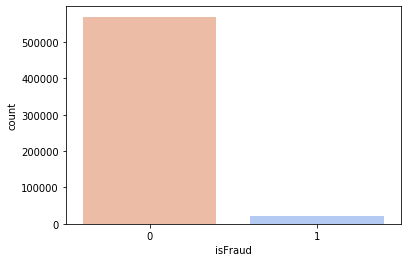

In [8]:
#checking imbalance data in training dataset
sns.countplot(train_df['isFraud'], palette="coolwarm_r")
plt.show()

In [9]:
#Timeseries split in hours and day (TransactionDT given in seconds)
train_df['day'] = (train_df['TransactionDT']//(3600*24)-1)%7

In [10]:
#Splitting on the basis of hours
train_df['hour'] = (train_df['TransactionDT']//(3600))%24

In [11]:
#Creating new feature on the basis of above analysis
def hourFeature(hour):
    if hour>3 and hour < 10:
        return "Alert"
    if hour ==10 or hour==17:
        return "Warning"
    if hour==2 or hour==3 or hour==18 or hour==23:
        return "Caution"
    else:
        return "Safe"

In [12]:
#Creating new attribute
train_df['Check'] = train_df['hour'].apply(hourFeature)

In [13]:
#checking how many values are there above 10000 in TransactionAmt

train_df[train_df['TransactionAmt'] > 10000]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,day,hour,Check
274336,3261336,0,6652360,31936.0,W,16075,514.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,23,Caution
274339,3261339,0,6652391,31936.0,W,16075,514.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,23,Caution


In [14]:
#only 2 values are present above 10000 and we can remove it since they are duplicates

In [15]:
#Working on values which are less than 10000
train_df = train_df[train_df['TransactionAmt'] < 10000]
#Taking logs and creating new feature because some values are high
train_df['LogTrAmt'] = np.log(train_df['TransactionAmt'])

In [16]:
def determine_cd3(value):
    if value==np.nan:
        return value
    else:
        if value > 150:
            return 'NF'
        else:
            return 'F'

In [17]:
#Adding attribute
train_df['Card3parameter'] = train_df['card3'].apply(determine_cd3)

In [18]:
#Creating new attribute 
def replace(value):
    if value==np.nan:
        return value
    if value=='debit or credit' or value=='charge card':
        return 'Other'
    else:
        return value

In [19]:
train_df['card6'] = train_df['card6'].apply(replace)

In [20]:
train_df = train_df[train_df['C1'] <= 2000]

In [21]:
#outliers above 2000
train_df = train_df[train_df['C2'] <= 2000]

In [22]:
#removing negative values from D-attributes because D-attributes are related to the 
#time-delta specifying the days between the previous transaction; hence, can not be negative

In [23]:
train_df.drop(train_df[train_df['D4'] < 0].index, inplace = True)

In [24]:
train_df.drop(train_df[train_df['D11'] < 0].index, inplace = True)

In [25]:
train_df.drop(train_df[train_df['D14'] < 0].index, inplace = True)

In [26]:
train_df.drop(train_df[train_df['D15'] < 0].index, inplace = True)

In [27]:
#Grouping similar types of phone model together

def group_DeviceInfo(di):
    di['DeviceName'] = di['DeviceInfo']
    di.loc[di['DeviceInfo'].str.contains('HUAWEI|HONOR', case=False, na=False, regex=True), 'DeviceName'] = 'HUAWEI'
    di.loc[di['DeviceInfo'].str.contains('OS', na=False, regex=False), 'DeviceName'] = 'APPLE'
    di.loc[di['DeviceInfo'].str.contains('Idea|TA', case=False, na=False), 'DeviceName'] = 'Lenovo'
    di.loc[di['DeviceInfo'].str.contains('Moto|XT|Edison', case=False, na=False), 'DeviceName'] = 'Moto'
    di.loc[di['DeviceInfo'].str.contains('MI|Mi|Redmi', na=False), 'DeviceName'] = 'Mi'
    di.loc[di['DeviceInfo'].str.contains('VS|LG|EGO', na=False), 'DeviceName'] = 'LG'
    di.loc[di['DeviceInfo'].str.contains('ONE TOUCH|ALCATEL', case=False, na=False, regex=False), 'DeviceName'] = 'ALCATEL'
    di.loc[di['DeviceInfo'].str.contains('ONE A', na=False, regex=False), 'DeviceName'] = 'ONEPLUS'
    di.loc[di['DeviceInfo'].str.contains('OPR6', na=False, regex=False), 'DeviceName'] = 'HTC'
    di.loc[di['DeviceInfo'].str.contains('Nexus|Pixel', case=False, na=False, regex=True), 'DeviceName'] = 'google'
    di.loc[di['DeviceInfo'].str.contains('STV', na=False, regex=False), 'DeviceName'] = 'blackberry'
    di.loc[di['DeviceInfo'].str.contains('ASUS', case=False, na=False, regex=False), 'DeviceName'] = 'ASUS'
    di.loc[di['DeviceInfo'].str.contains('BLADE', case=False, na=False, regex=False), 'DeviceName'] = 'ZTE'
    
    di['DeviceName'] = di['DeviceInfo'].astype('str').str.split(':', expand=True)[0].\
                                str.split('-', expand=True)[0].str.split(expand=True)[0]
    
    di.loc[di['DeviceInfo'].isin(['rv', 'SM', 'GT', 'SGH']), 'DeviceName'] = 'SAMSUNG'
    di.loc[di['DeviceInfo'].str.startswith('Z', na=False), 'DeviceName'] = 'ZTE'
    di.loc[di['DeviceInfo'].str.startswith('KF', na=False), 'DeviceName'] = 'Amazon'
    
    for i in ['D', 'E', 'F', 'G']:
        di.loc[di['DeviceInfo'].str.startswith(i, na=False), 'DeviceName'] = 'SONY'

    di.loc[di['DeviceName'].isin(di['DeviceName'].value_counts()\
                                 [di['DeviceName'].value_counts() < 100].index), 'DeviceName'] = 'Others'
    di['DeviceName'] = di['DeviceName'].str.upper()
    
    return di

In [28]:
train_df = group_DeviceInfo(train_df)

In [29]:
def setNaNvalue(value):
    if value=='NAN':
        return np.nan
    else:
        return value

In [30]:
train_df['DeviceName'] = train_df['DeviceName'].apply(setNaNvalue)

In [31]:
train_df['DeviceName']

0         SAMSUNG
1             IOS
2         WINDOWS
3             NaN
4           MACOS
           ...   
590535        NaN
590536        NaN
590537        NaN
590538        NaN
590539        NaN
Name: DeviceName, Length: 589693, dtype: object

In [32]:
cols_to_drop_id = ['id_01','id_02','id_03','id_04','id_05','id_06','id_10','id_11',
             'id_13','id_14','id_17','id_19','id_32', 'P_emaildomain','R_emaildomain','id_07','id_08',
                   'id_09','id_12','id_15','id_16','id_18','id_20','id_21','id_22','id_23','id_24','id_25','id_26',
                   'id_28','id_29','id_30','id_31','id_33','id_34','id_35','id_36','id_37', 'id_38', 'DeviceInfo']

train_df = train_df.drop(cols_to_drop_id, axis=1)     

In [33]:
#Applying Label Encoding

for i in ['card4', 'hour', 'card6','M1','M2','M3','M4','M5','M6','M7','M8','M9','ProductCD', 
          'DeviceType', 'DeviceName', 'Check']:
    le = LabelEncoder()
    le.fit(list(train_df[i].astype(str).values))
    train_df[i] = le.transform(list(train_df[i].astype(str).values))

In [34]:
one_value_cols = [col for col in train_df.columns if train_df[col].nunique() <= 1]
many_null_cols = [col for col in train_df.columns if train_df[col].isnull().sum() / train_df.shape[0] > 0.9]
big_top_value_cols = [col for col in train_df.columns if
                      train_df[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
cols_to_drop = list(set(many_null_cols + big_top_value_cols + one_value_cols))
cols_to_drop.remove('isFraud')
train_df = train_df.drop(cols_to_drop, axis=1)
train_df.fillna(-1, inplace=True)

In [35]:
train_df

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V336,V337,V338,V339,DeviceType,day,hour,Check,LogTrAmt,DeviceName
0,2987000,0,86400,68.500000,4,13926,-1.0,150.0,1,142.0,...,-1.0,-1.0,-1.0,-1.0,1,0,0,2,4.226562,23
1,2987001,0,86401,29.000000,4,2755,404.0,150.0,2,102.0,...,-1.0,-1.0,-1.0,-1.0,1,0,0,2,3.367188,9
2,2987002,0,86469,59.000000,4,4663,490.0,150.0,4,166.0,...,-1.0,-1.0,-1.0,-1.0,0,0,0,2,4.078125,30
3,2987003,0,86499,50.000000,4,18132,567.0,150.0,2,117.0,...,-1.0,-1.0,-1.0,-1.0,0,0,0,2,3.912109,33
4,2987004,0,86506,50.000000,1,4497,514.0,150.0,2,102.0,...,0.0,0.0,0.0,0.0,0,0,0,2,3.912109,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.000000,4,6550,-1.0,150.0,4,226.0,...,-1.0,-1.0,-1.0,-1.0,2,6,16,1,3.892578,33
590536,3577536,0,15811049,39.500000,4,10444,225.0,150.0,2,224.0,...,-1.0,-1.0,-1.0,-1.0,2,6,16,1,3.675781,33
590537,3577537,0,15811079,30.953125,4,12037,595.0,150.0,2,224.0,...,-1.0,-1.0,-1.0,-1.0,2,6,16,1,3.431641,33
590538,3577538,0,15811088,117.000000,4,7826,481.0,150.0,2,224.0,...,-1.0,-1.0,-1.0,-1.0,2,6,16,1,4.761719,33


In [36]:
train_algo = train_df[:424578]
val_algo = train_df[424578:]

In [37]:
x_train = train_algo.drop(['isFraud'],axis=1)
y_train = train_algo['isFraud']
x_val = val_algo.drop(['isFraud'],axis=1)
y_val = val_algo['isFraud']

In [38]:
del train_algo, val_algo

In [39]:
sc = StandardScaler()
x_train_stc = sc.fit_transform(x_train)
x_val_stc = sc.transform(x_val)

In [58]:
clf = SGDClassifier(loss="log")
clf.fit(x_train_stc,y_train)
y_train_pred = clf.predict_proba(x_train_stc)
y_val_pred = clf.predict_proba(x_val_stc)

In [59]:
print('train auc:', roc_auc_score(y_train,y_train_pred[:,1]))
print('val auc:', roc_auc_score(y_val,y_val_pred[:,1]))

train auc: 0.859952605612943
val auc: 0.8243837522066572


In [52]:
pd.crosstab(y_val, y_val_pred, rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1
Actual,,
0,157417,1985
1,4373,1340


In [53]:
#Confusion Matrix 
from sklearn.metrics import confusion_matrix

In [54]:
lgb_params = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.01,
                    'num_leaves': 2**8,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.7,
                    'n_estimators':1200,
                    'max_bin':255,
                    'verbose':-1,
                    'early_stopping_rounds':40, 
                }

In [55]:
import lightgbm as lgb
train_data = lgb.Dataset(x_train_stc,label=y_train)
val_data = lgb.Dataset(x_val_stc,label=y_val)
estimator = lgb.train(lgb_params, train_set=train_data, valid_sets=[train_data, val_data], verbose_eval=100)

Training until validation scores don't improve for 40 rounds
[100]	training's auc: 0.929261	valid_1's auc: 0.885101
[200]	training's auc: 0.953254	valid_1's auc: 0.897753
[300]	training's auc: 0.971217	valid_1's auc: 0.909201
[400]	training's auc: 0.983179	valid_1's auc: 0.914687
[500]	training's auc: 0.989278	valid_1's auc: 0.917795
[600]	training's auc: 0.992867	valid_1's auc: 0.91976
[700]	training's auc: 0.995137	valid_1's auc: 0.920343
[800]	training's auc: 0.996688	valid_1's auc: 0.921033
Early stopping, best iteration is:
[775]	training's auc: 0.996343	valid_1's auc: 0.921058


In [71]:
 clf = xgb.XGBClassifier(
        learning_rate=0.009,
        max_depth=10,
        boosting='gbdt',
        objective='binary:logistic',
        metric='auc',
        seed=4,
        num_iterations=10000,
        early_stopping_round=100,
        verbose_eval=200,
        num_leaves=64,
        feature_fraction=0.8,
        bagging_fraction=0.8,
        bagging_freq=5)

In [47]:
clf.fit(x_train_stc, y_train, verbose=True, eval_set=[(x_val_stc, y_val)], early_stopping_rounds = 3)

[0]	validation_0-error:0.029355
Will train until validation_0-error hasn't improved in 3 rounds.
[1]	validation_0-error:0.02924
[2]	validation_0-error:0.029428
[3]	validation_0-error:0.029313
[4]	validation_0-error:0.02921
[5]	validation_0-error:0.029222
[6]	validation_0-error:0.029295
[7]	validation_0-error:0.029234
Stopping. Best iteration:
[4]	validation_0-error:0.02921



XGBClassifier(bagging_fraction=0.8, bagging_freq=5, base_score=0.5,
              booster='gbtree', boosting='gbdt', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_round=100,
              feature_fraction=0.8, gamma=0, learning_rate=0.009,
              max_delta_step=0, max_depth=10, metric='auc', min_child_weight=1,
              missing=None, n_estimators=100, n_jobs=1, nthread=None,
              num_iterations=10000, num_leaves=64, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=4, silent=None, subsample=1, ...)

In [62]:
#SVM

clf = SGDClassifier(loss="hinge")
clf.fit(x_train_stc,y_train)
y_train_pred=clf.predict(x_train_stc)
y_val_pred = clf.predict(x_val_stc)

In [63]:
print('train auc:',roc_auc_score(y_train,y_train_pred))
print('val auc:',roc_auc_score(y_val,y_val_pred))

train auc: 0.6230678356791511
val auc: 0.5998699425379267


In [64]:
pd.crosstab(y_val, y_val_pred, rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1
Actual,,
0,158038,1364
1,4523,1190


In [67]:
rand_clas = RandomForestClassifier(n_jobs=2, random_state=0, n_estimators=100, bootstrap = True)
rand_clas.fit(x_train_stc,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [68]:
predictions = rand_clas.predict(x_val_stc)

In [69]:
pd.crosstab(y_val, predictions, rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1
Actual,,
0,159020,382
1,3954,1759


In [70]:
print('val auc:', roc_auc_score(y_val,predictions))

val auc: 0.6527489097275091
